<a href="https://colab.research.google.com/github/satoruk-icepp/MEG2XEC/blob/master/MEG2Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%writefile .comet.config
[comet]
api_key=mIel5ZAPOioTs0Cij75dSSQXs
logging_file = /tmp/comet.log
logging_file_level = info


Overwriting .comet.config


In [3]:
! [ ! -z "$COLAB_GPU" ] && pip install skorch comet_ml

In [0]:
from comet_ml import Experiment
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm, tqdm_notebook
from scipy.optimize import curve_fit

In [5]:
experiment = Experiment(project_name="CWreg")
curtime = datetime.now().strftime("%Y%m%d-%H%M%S")
experiment.set_name("%s"%(curtime))
params={'batch_size' : 200,
        'learning_rate':0.1,
        'dropout_conv':0.1,
        'dropout_fc':0.1,
        'optim':"Adam",
        'weight_decay':1e-05,
        'Nresblock':0,
        'Nsd':0,
        'Wthreshold':np.log(0.2+1e-02)/2.5+1,
        'weightstd':0.0001,
        'Nlayer':32,
        'Nfc':2,
        'Nfcnodes':256,
        'LRgamma':0.1
}
experiment.log_parameters(params)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/satoruk-icepp/cwreg/4f1c2c741b8340a59037830014f93f70



In [0]:
device = torch.device('cuda:0')

In [0]:
# csv_data  = pd.read_csv('/content/drive/My Drive/MEG2CW/fout.csv')
# names=['E','U','V','W','PT','PP','UR','VR','WR']
# PMnames = ['PM%d'%(i) for i in range(4760)]
# names = names+PMnames
# csv_data  = pd.read_csv('/content/drive/My Drive/MEG2CW/fout_norm.csv',names=names)
csv_data  = pd.read_csv('/content/drive/My Drive/MEG2CW/fout_norm.csv')

In [8]:
print(csv_data.shape)
print(params['Wthreshold'])
# csv_data = csv_data[csv_data['w']<params['Wthreshold']]
csv_data

(53208, 4770)
0.3757409006941327


,Energy,u,v,w,ptheta,pphi,urec,vrec,wrec,PM_0,PM_1,PM_2,PM_3,PM_4,PM_5,PM_6,PM_7,PM_8,PM_9,PM_10,PM_11,PM_12,PM_13,PM_14,PM_15,PM_16,PM_17,PM_18,PM_19,PM_20,PM_21,PM_22,PM_23,PM_24,PM_25,PM_26,PM_27,PM_28,PM_29,PM_30,...,PM_4721,PM_4722,PM_4723,PM_4724,PM_4725,PM_4726,PM_4727,PM_4728,PM_4729,PM_4730,PM_4731,PM_4732,PM_4733,PM_4734,PM_4735,PM_4736,PM_4737,PM_4738,PM_4739,PM_4740,PM_4741,PM_4742,PM_4743,PM_4744,PM_4745,PM_4746,PM_4747,PM_4748,PM_4749,PM_4750,PM_4751,PM_4752,PM_4753,PM_4754,PM_4755,PM_4756,PM_4757,PM_4758,PM_4759,flag
0,0.176200,0.647425,0.402845,0.406430,-0.430562,-0.315788,0.611859,0.407013,0.386388,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0001,0.0001,0.0001,0.0002,0.0001,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,0.0002,0.0001,0.0000,0.0001,0.0002,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0003,0.0002,0.0029,0.0032,0.0014,0.0026,0.0033,0.0042,0.0031,0.0025,0.0039,0.0015,0.0024,0.0005,0.0016,0.0006,0.0017,0.0020,0.0014,0.0012,0
1,0.154239,-0.550071,0.363598,-0.479323,0.412274,-0.285022,-0.551514,0.366742,-0.548834,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0028,0.0017,0.0033,0.0035,0.0032,0.0022,0.0018,0.0023,0.0010,0.0021,0.0012,0.0019,0.0019,0.0022,0.0011,0.0010,0.0016,0.0011,0
2,0.176200,0.224333,-0.437471,0.610209,-0.142812,0.342931,0.228618,-0.453216,0.693381,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0033,0.0041,0.0037,0.0039,0.0036,0.0028,0.0020,0.0009,0.0010,0.0012,0.0019,0.0019,0.0023,0.0027,0.0029,0.0035,0.0024,0.0026,0.0024,0.0017,0.0014,0.0025,0.0014,0.0016,0.0013,0.0008,0.0015,0.0019,0.0021,0.0012,0.0026,0.0026,0.0021,0.0033,0.0022,0.0028,0.0032,0.0033,0.0056,0
3,0.150187,0.642363,0.384732,0.575611,-0.403170,-0.301589,0.591816,0.380710,0.581872,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,0.0000,0.0000,0.0001,0.0000,0.0001,0.0002,0.0001,0.0002,0.0000,0.0001,0.0000,...,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0003,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0002,0.0000,0.0000,0.0020,0.0043,0.0018,0.0022,0.0020,0.0035,0.0038,0.0016,0.0023,0.0016,0.0019,0.0018,0.0013,0.0012,0.0018,0.0015,0.0019,0.0013,0
4,0.176200,-0.244407,0.660570,0.186308,0.177176,-0.517817,-0.247431,0.654285,0.209709,0.0000,0.0002,0.0001,0.0001,0.0002,0.0004,0.0001,0.0001,0.0003,0.0005,0.0005,0.0005,0.0002,0.0003,0.0004,0.0003,0.0001,0.0002,0.0004,0.0005,0.0003,0.0004,0.0001,0.0001,0.0003,0.0003,0.0001,0.0001,0.0002,0.0000,0.0001,...,0.0000,0.0001,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0021,0.0017,0.0020,0.0012,0.0009,0.0012,0.0014,0.0009,0.0012,0.0008,0.0011,0.0008,0.0009,0.0002,0.0003,0.0005,0.0004,0.0005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53203,0.165990,0.303824,0.508643,0.122589,-0.221882,-0.398722,0.302143,0.510321,0.138353,0.0000,0.0000,0.0000,0.0001,0.0000,0.0002,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.0001,0.0000,0.0000,0.0001,0.0000,0.0002,0.0000,0.

In [0]:
csv_data_numpy = csv_data.to_numpy()
del csv_data

In [0]:
Energy  = csv_data_numpy[:,0]
UVW     = csv_data_numpy[:,1:4]
DIR     = csv_data_numpy[:,4:6]
UVWREC  = csv_data_numpy[:,6:9]
PMResponse = csv_data_numpy[:,9:4101]

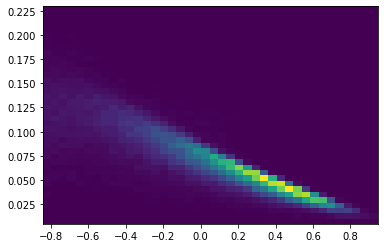

In [11]:
Energy     = Energy.reshape(-1,1)
PMResponse = PMResponse.reshape(-1,93,44)
indx_U = np.arange(-21.5,22.5)
indx_V = np.arange(-46,47)
# for i in np.arange(-21.5,22.5):
PMU = (np.dot(np.sum(PMResponse[:],axis=1),indx_U)/np.sum(np.sum(PMResponse[:],axis=1),axis=1))/22
PMV = (np.dot(np.sum(PMResponse[:],axis=2),indx_V)/np.sum(np.sum(PMResponse[:],axis=2),axis=1))/46.5
PMU = PMU.reshape(-1,1)
PMV = PMV.reshape(-1,1)
PMURMS = np.sqrt(np.mean(np.square(np.sum(PMResponse[:],axis=1)),axis=1)).reshape(-1,1)
PMVRMS = np.sqrt(np.mean(np.square(np.sum(PMResponse[:],axis=2)),axis=1)).reshape(-1,1)
plt.hist2d(UVW[:,2],PMURMS.reshape(-1),bins=[40,40])
ADD = np.concatenate((PMU,PMV,PMURMS,PMVRMS),axis=1)
# print(ADD)

In [0]:
del csv_data_numpy

In [0]:
PMResponse = PMResponse.reshape(-1,4092)
# PMResponse = PMResponse/PMResponseScale

In [0]:
Energy        = torch.tensor(Energy).float()
UVW           = torch.tensor(UVW).float()
DIR           = torch.tensor(DIR).float()
ADD           = torch.tensor(ADD).float()
UVWREC        = torch.tensor(UVWREC).float()
PMResponse    = torch.tensor(PMResponse).float()

In [15]:
from torch.utils.data.dataset import Subset
BATCH_SIZE = params["batch_size"]
calo_dataset    = utils.TensorDataset(Energy,UVW,UVWREC,DIR,ADD,PMResponse)
data_size =  len(calo_dataset)
full_size = int(data_size/1000)*1000
print(data_size)
train_dataset = Subset(calo_dataset,list(range(0,int(0.8*full_size))))
val_dataset = Subset(calo_dataset,list(range(int(0.8*full_size),full_size)))
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              pin_memory=True, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=len(val_dataset), 
                                              pin_memory=True, shuffle=True)

53208


In [0]:
def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self,input_size):
        super(ResidualBlock, self).__init__()        
        self.conv1 = nn.Conv2d(input_size,input_size,3,padding=1)
        self.conv2 = nn.Conv2d(input_size,input_size,3,padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv1.out_channels)
        self.bn2 = nn.BatchNorm2d(self.conv2.out_channels)        
        self.activation = nn.LeakyReLU(0.0)
    def forward(self,xraw):
        x = self.activation(self.bn1(self.conv1(xraw)))
        x = self.activation(self.bn2(self.conv2(x))+xraw)
        return x

In [0]:
class Regressor(nn.Module):
    def __init__(self, dropout_conv =0.0,dropout_fc=0.0,Nresblock=0,Nsd=0,Nlayer=32,Nfc=4,Nfcnodes=256):
        super(Regressor, self).__init__()
        # self.fc1 = nn.Linear(4092,256)
        self.conv1 = nn.Conv2d(1, Nlayer, kernel_size=(10,10), stride = 5, padding = (1,3))#(93+6,44+6)->24,12
        self.conv2 = nn.Conv2d(
            self.conv1.out_channels, 
            self.conv1.out_channels*2, 
            kernel_size=(4, 3), 
            stride=2
            # ,padding = (1,1)
        )#24*12->12*6
        self.conv3 = nn.Conv2d(
            self.conv2.out_channels, 
            self.conv2.out_channels*2, 
            3
            # ,stride=2
        )#12*6->6*3
        self.convsd = nn.Conv2d(
            self.conv1.out_channels, 
            self.conv1.out_channels, 
            3,
            padding=1
        )#12*6->6*3 
        self.rb = ResidualBlock(self.conv1.out_channels)
        self.fcstart = nn.Linear(self.conv3.out_channels*12+7,Nfcnodes)
        self.Nfc = Nfc
        self.fc=[nn.Linear(self.fcstart.out_features//2**i,self.fcstart.out_features//2**(i+1)).to(device) for i in range(self.Nfc)]
        self.fcend = nn.Linear(self.fcstart.out_features//2**(Nfc),3)
        
        self.bn1 = nn.BatchNorm2d(self.conv1.out_channels)
        self.bn2 = nn.BatchNorm2d(self.conv2.out_channels)
        self.bn3 = nn.BatchNorm2d(self.conv3.out_channels)
        self.dropout1 = nn.Dropout(dropout_conv)
        self.dropoutfc = nn.Dropout(dropout_fc)
        self.Nresblock = Nresblock
        self.Nsd = Nsd
        
    def forward(self, x, uvw_rec):
        # x = F.relu(self.dropout_fc1(self.fc1(x)))
        x = x.view(x.shape[0],1,-1)
        
        # x_mppc,x_pmt = x.split(4092)
        x = x.view(x.shape[0],1,93,44)
        x = F.relu(self.bn1(self.conv1(x)))
        for i in range(self.Nresblock):
            x = self.dropout1(self.rb(x))
        for i in range(self.Nsd):
            x = F.relu(self.dropout1(self.bn1(self.convsd(x))))
        x = F.relu(self.dropout1(self.bn2(self.conv2(x))))
        x = F.relu(self.dropout1(self.bn3(self.conv3(x))))
        
        x = x.view(x.shape[0],self.conv3.out_channels*12)
        x = torch.cat([x,uvw_rec],dim=1)
        x = F.relu(self.fcstart(x))
        for i in range(self.Nfc):
            x = F.relu(self.dropoutfc(self.fc[i](x)))
        # x = F.relu(self.dropoutfc(self.fc3(x)))
        # x = F.relu(self.dropoutfc(self.fc4(x)))
        x = self.fcend(x)
        return torch.tanh(x)
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [19]:
model = Regressor(
    params["dropout_conv"],
    params["dropout_fc"],
    params["Nresblock"],
    params["Nsd"],
    params['Nlayer'],
    params['Nfc'],
    params['Nfcnodes']
    ).to(device)
print(model)
# model.weight_init(mean=0.0, std=params['weightstd'])

Regressor(
  (conv1): Conv2d(1, 32, kernel_size=(10, 10), stride=(5, 5), padding=(1, 3))
  (conv2): Conv2d(32, 64, kernel_size=(4, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (convsd): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rb): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.0)
  )
  (fcstart): Linear(in_features=1543, out_features=256, bias=True)
  (fcend): Linear(in_features=64, out_features=3, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [0]:
# learning_rate = 0.001
# opt = optim.Adam(regressor.parameters(), lr=learning_rate)
opt = optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
scheduler = MultiStepLR(opt, milestones=[50,100,200,400], gamma=params["LRgamma"])

In [0]:
Energy_mean, UVW_mean, DIR_mean = Energy.mean(dim=0).to(device), UVW.mean(dim=0).to(device), DIR.mean(dim=0).to(device)
EZRP_mean = torch.cat([Energy_mean, UVW_mean]).to(device)
UVWDIR_mean = torch.cat([UVW_mean, DIR_mean]).to(device)
def metric_relative_mse(y_pred,y_true):
    y_true_mean = y_true.mean(dim=0)
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - EZRP_mean).pow(2).mean(dim=0)).sum()).sqrt()
    return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVW_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true[:,2] - y_pred[:,2]).pow(2).mean(dim=0) / (y_true[:,2] - UVW_mean[2]).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVWDIR_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - Energy_mean).pow(2).mean(dim=0)).sum()).sqrt()

In [0]:
# loss_fn = torch.nn.SmoothL1Loss().to(device)
loss_fn = torch.nn.L1Loss().to(device)

In [0]:
def run_training(epochs=100):
    # iterating over epochs...
    for epoch in tqdm(range(epochs)):
        first = True
        for Energy_b, UVW_b, UVWREC_b, DIR_b,ADD_b, PMResponse_b in train_dataloader:
        # moving them to device(for example, cuda-device)
            Energy_b, UVW_b, UVWREC_b, DIR_b,ADD_b, PMResponse_b = Energy_b.to(device), \
                                            UVW_b.to(device), \
                                            UVWREC_b.to(device), \
                                            DIR_b.to(device), \
                                            ADD_b.to(device), \
                                            PMResponse_b.to(device)

#             pred = regressor(EnergyDeposit_b)
            model.train()
            UVWDIR_b = torch.cat([UVW_b,DIR_b],dim=1)
            UVWDIRrec_b = torch.cat([UVWREC_b,DIR_b],dim=1)
            # pred = model(PMResponse_b,UVWREC_b)
            # pred = model(PMResponse_b,torch.zeros(UVW_b.shape[0],3).to(device))
            pred = model(PMResponse_b,torch.cat([ADD_b,UVWREC_b],dim=1))
            # loss        = loss_fn(pred, torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1))
            # loss        = loss_fn(pred, torch.cat([Energy_b,ZRP_b],dim=1))
            loss        = loss_fn(pred, UVW_b)
            loss_rec    = loss_fn(UVWREC_b, UVW_b)
            # loss        = loss_fn(pred[:,2], UVW_b[:,2])
            # loss_rec    = loss_fn(UVWREC_b[:,2], UVW_b[:,2])
            # loss        = loss_fn(pred, Energy_b)

            # model.train()
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        with torch.no_grad():
            model.eval()
            pred = model(PMResponse_b,torch.cat([ADD_b,UVWREC_b],dim=1))
            train_mse       = metric_relative_mse(pred, UVW_b).item()
            train_mse_rec   = metric_relative_mse(UVWREC_b, UVW_b).item()
        experiment.log_metric("learning_rate", scheduler.get_lr(),step=epoch)
        experiment.log_metric("train_loss", loss.item(),step=epoch)
        experiment.log_metric("train_mse", train_mse,step=epoch)
        experiment.log_metric("train_loss_rec", loss_rec.item(),step=epoch)
        experiment.log_metric("train_mse_rec", train_mse_rec,step=epoch)

        if epoch%10==0:
            plt.figure(figsize=(20,12))
            grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)
            for idim in range(3):
                plt.subplot(grid[2,idim])
                plt.hist2d(UVW_b[:,2].cpu().detach().numpy(),UVW_b[:,idim].cpu().detach().numpy()-pred[:,idim].cpu().detach().numpy(),
                        range=[[-1,1],[-0.3,0.3]],
                        bins = [40,40]
                        )
        scheduler.step()
        for Energy_b, UVW_b, UVWREC_b, DIR_b,ADD_b, PMResponse_b in val_dataloader:
    # moving them to device(for example, cuda-device)
            Energy_b, UVW_b, UVWREC_b, DIR_b,ADD_b, PMResponse_b = Energy_b.to(device), \
                                            UVW_b.to(device), \
                                            UVWREC_b.to(device), \
                                            DIR_b.to(device), \
                                            ADD_b.to(device), \
                                            PMResponse_b.to(device)

            break

#             pred = regressor(EnergyDeposit_b)
        with torch.no_grad():
            model.eval()
            UVWDIR_b = torch.cat([UVW_b,DIR_b],dim=1)
            UVWDIRrec_b = torch.cat([UVWREC_b,DIR_b],dim=1)
            # pred = model(PMResponse_b,UVWREC_b)
            # pred = model(PMResponse_b,torch.zeros(UVW_b.shape[0],3).to(device))
            pred = model(PMResponse_b,torch.cat([ADD_b,UVWREC_b],dim=1))
            # loss        = loss_fn(pred, torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1))
            # val_loss        = loss_fn(pred, torch.cat([Energy_b,ZRP_b],dim=1))
            # val_loss        = loss_fn(pred, UVWDIR_b)
            val_loss        = loss_fn(pred, UVW_b)
            val_loss_rec    = loss_fn(UVWREC_b, UVW_b)
            # val_loss        = loss_fn(pred[:,2], UVW_b[:,2])
            # val_loss_rec    = loss_fn(UVWREC_b[:,2], UVW_b[:,2])
            # val_loss        = loss_fn(pred, Energy_b)
#             loss        = loss_fn(pred, ParticleType_b)
            # val_mse   = metric_relative_mse(pred, torch.cat([Energy_b, ZRP_b], dim=1)).item()
            val_mse       = metric_relative_mse(pred, UVW_b).item()
            val_mse_rec   = metric_relative_mse(UVWREC_b, UVW_b).item()
            # val_mse   = metric_relative_mse(pred, Energy_b).item()
            # val_mse   = 0
        experiment.log_metric("val_loss", val_loss.item(),step=epoch)
        experiment.log_metric("val_loss_rec", val_loss_rec.item(),step=epoch)
        experiment.log_metric("val_mse", val_mse,step=epoch)
        experiment.log_metric("val_mse_rec", val_mse_rec,step=epoch)
        resolution     =[np.sqrt(np.mean((UVW_b[:,idim].cpu().detach().numpy()-pred[:,idim].cpu().detach().numpy())**2)) for idim in range(3)]
        resolution_lpf =[np.sqrt(np.mean((UVW_b[:,idim].cpu().detach().numpy()-UVWREC_b[:,idim].cpu().detach().numpy())**2)) for idim in range(3)]
        experiment.log_metric("u_resolution", resolution[0],step=epoch)
        experiment.log_metric("v_resolution", resolution[1],step=epoch)
        experiment.log_metric("w_resolution", resolution[2],step=epoch)
        experiment.log_metric("u_resolution_lpf", resolution_lpf[0],step=epoch)
        experiment.log_metric("v_resolution_lpf", resolution_lpf[1],step=epoch)
        experiment.log_metric("w_resolution_lpf", resolution_lpf[2],step=epoch)
        if epoch%10==0:
            # plt.figure(figsize=(20,12))
            # grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
            for idim in range(3):
                plt.subplot(grid[0,idim])
                plt.hist(UVW_b[:,idim].cpu().detach().numpy()-pred[:,idim].cpu().detach().numpy(),range=(-0.5,0.5),bins=80)
                plt.title("%f"%(np.sqrt(np.mean((UVW_b[:,idim].cpu().detach().numpy()-pred[:,idim].cpu().detach().numpy())**2))))
                plt.subplot(grid[1,idim])
                plt.hist2d(UVW_b[:,2].cpu().detach().numpy(),UVW_b[:,idim].cpu().detach().numpy()-pred[:,idim].cpu().detach().numpy(),
                        range=[[-1,1],[-0.3,0.3]],
                        bins = [40,40]
                        )
            
            experiment.log_figure(figure=plt)
            plt.close()
        

In [0]:
with experiment.train():
    run_training(10000)

  3%|▎         | 260/10000 [16:48<9:51:01,  3.64s/it] 